In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
# for known bug TensorFlow: Blas GEMM launch failed
physical_devices = tf.config.list_physical_devices('GPU') 
print("GPU detected :", physical_devices)
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Embedding,LSTM,GRU,Conv1D,MaxPooling1D,GlobalMaxPooling1D

from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import cm

import itertools

data_train = pd.read_csv('X_train_rakuten_afterEDA_preprocessing.csv',index_col=0)
data_train = data_train.reset_index(drop=False)
data_train.shape



GPU detected : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Using TensorFlow backend.


(84613, 6)

In [2]:
#display columns including product text (designation and designation_token_final)
data_train.head()

,designation_orig,nom_img,lang_designation,designation,prdtypecode,designation_token_final
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,image_1263597046_product_3804725264.jpg,de,olivia: notebook personnalise / pages / punks...,10,"['notebook', 'page', 'design']"
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,image_1008141237_product_436067568.jpg,fr,journal des art (le) n° du // art et son ma...,2280,"['journal', 'art', 'art', 'marche', 'salon', '..."
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,image_938777978_product_201115110.jpg,fr,grand stylet ergonomique bleu gamepad nintendo...,50,"['stylet', 'ergonomique', 'gamepad', 'nintendo..."
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,image_457047496_product_50418756.jpg,fr,peluche donald europe disneyland (marionn...,1280,"['peluche', 'donald', 'europe', 'disneyland', ..."
4,La Guerre Des Tuques Luc a des idées de grande...,image_1077757786_product_278535884.jpg,fr,la guerre des tuques luc a des idees de grande...,2705,"['guerre', 'luc', 'idees', 'grandeur', 'vouloi..."


In [3]:
#for the moment, products prediction from text and image are completely handled separately 
#Do not forget for future merge that samples has been deleted due to image size null or too small (less than 2kb) 
#so a common dataframe will be built in this case 

In [4]:
# column designation_token_final is the result of preprocessing text cleaning (stopwords and so on) under tokens form
# so, we transform it again into text string in designation_str_tokens that is now the features data column
# to prepare the association between each word and a integer number (index in dictionary of full vocabulary describing products)
import re
data_train['designation_str_tokens'] = ""
for i in range(len(data_train)):
    data_train['designation_str_tokens'].iloc[i] += "".join(data_train['designation_token_final'].iloc[i]) 

data_train['designation_str_tokens'] = data_train['designation_str_tokens'].map(lambda x: re.sub(r',', '', x))
data_train['designation_str_tokens'] = data_train['designation_str_tokens'].map(lambda x: re.sub(r"'", '', x))

name_class = ['editions','magazines',"equipement_playstation","jouets_enfant","livres","fournitures_scolaires","materiel_jardin","mobilier_interieur","jeux_enfants","literie","livres_par_lot","figurine","materiel_piscine","univers_de_fiction","equipements_telecommandes","materiel_jeux_video","jeux_de_cartes_collection","decoration","jeux_video","console_de_jeu","materiel_bebe","peche_lampe_plein_air","materiel_animaux_compagnie","jeux_sur_PC","accessoires_outil","articles_nourriture","vetements_nouveau-né_et_billard_flechettes"] 
list_class = [10, 2280 ,  50 ,1280 ,2705, 2522, 2582, 1560, 1281, 1920, 2403, 1140, 2583, 1180, 1300 ,2462, 1160, 2060 , 40,   60 ,1320 ,1302 ,2220 ,2905, 2585, 1940 ,1301]       
list_class_onehot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

data_train['class_onehot']= 0
for i in range(len(data_train)):
    index = list_class.index(data_train['prdtypecode'].iloc[i])
    data_train['class_onehot'].iloc[i] = list_class_onehot[index]


#training and validation set , not yet test set 
#only designation_str_tokens column kept
target = data_train.class_onehot
text = data_train.designation_str_tokens

#random split of data into a training set and a validation/test set
X_train, X_test, y_train, y_test = train_test_split(text,target, test_size=0.2, random_state=66)


C:\Users\admin\.conda\envs\tf-keras-gpu-test\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [23]:
display(X_test.head(5))
display(y_test.head(5))
display(data_train[['prdtypecode','class_onehot']].head(50))
# target is now a list of classes from 0 to 26 rtaher than discrete values of Rakuten catalog

42332    [happy father day canape lire accueil decorati...
13423                                          [dino oeuf]
12664    [nappe noel imprimer rectangle table cover hol...
37813    [lot paquet daim look sachet sac pochette doub...
60479    [hamac boi enfant hesperid hamac boi enfant ma...
Name: designation_str_tokens, dtype: object

42332    9
13423    8
12664    7
37813    6
60479    6
Name: class_onehot, dtype: int64

,prdtypecode,class_onehot
0,10,0
1,2280,1
2,50,2
3,1280,3
4,2705,4
5,2280,1
6,10,0
7,2522,5
8,1280,3
9,2582,6


In [6]:
# tokenizer definition
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=49718)
# update tokenizer dictionary 
tokenizer.fit_on_texts(X_train)

#Store dictionary associating word and index in variable word2idx
word2idx = tokenizer.word_index

#Store dictionary associating index and word in variable idx2word
idx2word = tokenizer.index_word

#Store dictionary size
vocab_size = tokenizer.num_words

print("vocabulary dictionary size imposed :",vocab_size)
print("length of dictionary :",len(word2idx))
print("")
print("notebook to be converted in :",word2idx["notebook"])
print("page to be converted in :",word2idx["page"])
print("design to be converted in :",word2idx["design"])
print("")
print("entire dictionary :")
print(idx2word)

vocabulary dictionary size imposed : 49718
length of dictionary : 49718

notebook to be converted in : 8463
page to be converted in : 415
design to be converted in : 42

entire dictionary :
{1: 'piscine', 2: 'eau', 3: 'enfant', 4: 'jeu', 5: 'materiel', 6: 'acier', 7: 'oreiller', 8: 'coussin', 9: 'lumiere', 10: 'decoration', 11: 'faire', 12: 'batterie', 13: 'sac', 14: 'produire', 15: 'jouet', 16: 'main', 17: 'led', 18: 'materiau', 19: 'hauteur', 20: 'image', 21: 'cadeau', 22: 'type', 23: 'mode', 24: 'carte', 25: 'paquet', 26: 'protection', 27: 'raison', 28: 'interieur', 29: 'maison', 30: 'pompe', 31: 'contenu', 32: 'mesure', 33: 'permettre', 34: 'forme', 35: 'voiture', 36: 'plastique', 37: 'produit', 38: 'emballage', 39: 'sol', 40: 'anti', 41: 'filtration', 42: 'design', 43: 'volume', 44: 'autre', 45: 'temps', 46: 'marqu', 47: 'noel', 48: 'forfait', 49: 'couverture', 50: 'kit', 51: 'air', 52: 'durable', 53: 'manuel', 54: 'parfait', 55: 'fonction', 56: 'systeme', 57: 'tissu', 58: 'utilis

In [7]:
# transform each designation text into a sequence of integers (word index)
#only for words known by tokenizer

X_train_int = tokenizer.texts_to_sequences(X_train)

X_test_int = tokenizer.texts_to_sequences(X_test)



In [15]:
#cell to be used for models with embedding layer expecting text input fixed size of 350 words
from keras import preprocessing

#number of word considered by embedding layer as all possible characteristics (dictionary of vocabulary)
max_features = 49800

#text truncated if its length is higher
maxlen=350



#transform list of integers into a tensor2D
X_train_2D = tf.keras.preprocessing.sequence.pad_sequences(X_train_int,maxlen=maxlen,padding='post',truncating='post')
X_test_2D = tf.keras.preprocessing.sequence.pad_sequences(X_test_int,maxlen=maxlen,padding='post',truncating='post')
print("tensor2D size of the test set :",X_test_2D.shape)
print("first raw text of test set  :\n",X_test.iloc[0])
print("")
print("text converted into integers list:",X_test_int[0])
print("")
print("first tensor :\n",X_test_2D[0])


tensor2D size of the test set : (16923, 350)
first raw text of test set  :
 [happy father day canape lire accueil decoration coussin festival taie oreiller couverture happy father day canape lit decoration pillow festival coussin case specification couvertur parfait place canape cafe bibliothequ livre party club magasin materiau forme lin place amovible lavable type tai oreiller deviation mesure comprendre forfait forfait tai oreiller]

text converted into integers list: [1285, 27138, 2584, 90, 978, 304, 10, 8, 811, 60, 7, 49, 1285, 27138, 2584, 90, 106, 10, 821, 811, 8, 436, 83, 1486, 54, 84, 90, 293, 941, 81, 416, 677, 616, 18, 34, 226, 84, 287, 252, 22, 211, 7, 693, 32, 102, 48, 48, 211, 7]

first tensor :
 [ 1285 27138  2584    90   978   304    10     8   811    60     7    49
  1285 27138  2584    90   106    10   821   811     8   436    83  1486
    54    84    90   293   941    81   416   677   616    18    34   226
    84   287   252    22   211     7   693    32   102    48 

In [9]:
model = Sequential()


model.add(Embedding(max_features+1,512,input_length=maxlen))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(27,activation='softmax'))


model.summary()
# trainable parameters number for embedding layer = 49801 (dictionary size) * 512 (dense vector size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 350, 512)          25498112  
_________________________________________________________________
flatten (Flatten)            (None, 179200)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                11468864  
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                1755      
Total params: 36,968,731
Trainable params: 36,968,731
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#Note : metrics use accuracy for classification and mae or mse for regression (continuous target)

In [11]:
import time

start = time.time()

history = model.fit(X_train_2D, y_train.values,
    batch_size = 32,
    epochs=10,
    validation_data = [X_test_2D, y_test.values])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

Train on 67690 samples, validate on 16923 samples
Epoch 1/10
67690/67690 [==============================] - 446s 7ms/sample - loss: 1.2725 - accuracy: 0.6315 - val_loss: 0.7002 - val_accuracy: 0.7921
Epoch 2/10
67690/67690 [==============================] - 439s 6ms/sample - loss: 0.4061 - accuracy: 0.8804 - val_loss: 0.6861 - val_accuracy: 0.8093
Epoch 3/10
67690/67690 [==============================] - 428s 6ms/sample - loss: 0.2154 - accuracy: 0.9382 - val_loss: 0.7953 - val_accuracy: 0.8025
Epoch 4/10
67690/67690 [==============================] - 429s 6ms/sample - loss: 0.1623 - accuracy: 0.9573 - val_loss: 0.9455 - val_accuracy: 0.8001
Epoch 5/10
67690/67690 [==============================] - 432s 6ms/sample - loss: 0.1254 - accuracy: 0.9680 - val_loss: 1.0787 - val_accuracy: 0.7950
Epoch 6/10
67690/67690 [==============================] - 431s 6ms/sample - loss: 0.1116 - accuracy: 0.9734 - val_loss: 1.2574 - val_accuracy: 0.7957
Epoch 7/10
67690/67690 [==========================

Text(0.5, 1.0, 'loss during training and validation for Embedding and Dense classifier')

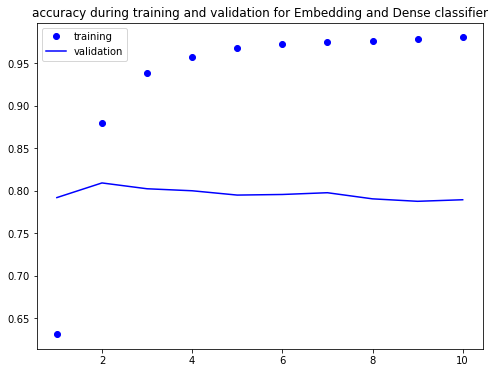

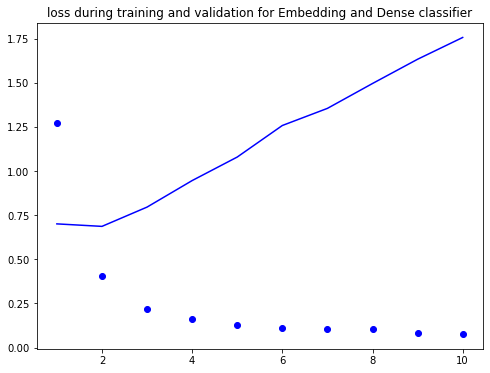

In [12]:
#display accuracy and loss for both training and validation set of text designation_str_tokens after epochs execution
#typical overfitting neural network 
#with accuracy increasing linearly on training set to almost reaching 100%
#and stabilized around 79,5% for validation
#Note : no callback yet configured to stop training on criterii
#
#unfortunately, no callback yet configured to stop training after epoch 3 only  !!!!

#
#next step using a model with a RNN layer after the Embedding one and before the final Dense classifier
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)
plt.figure(figsize=(8,6))
plt.plot(epochs,acc,'bo',label='training')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('accuracy during training and validation for Embedding and Dense classifier')
plt.legend();

plt.figure(figsize=(8,6))     
plt.plot(epochs,loss,'bo',label='training')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('loss during training and validation for Embedding and Dense classifier')

In [9]:
model1 = Sequential()


model1.add(Embedding(max_features+1,512,input_length=maxlen))
model1.add(LSTM(512))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(27,activation='softmax'))


model1.summary()

ERROR! Session/line number was not unique in database. History logging moved to new session 156
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 512)          25498112  
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                1755      
Total params: 27,631,899

In [10]:
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
import time

start = time.time()

history1 = model1.fit(X_train_2D, y_train.values,
    batch_size = 32,
    epochs=10,
    validation_data = [X_test_2D, y_test.values])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

Train on 67690 samples, validate on 16923 samples
Epoch 1/10
67690/67690 [==============================] - 497s 7ms/sample - loss: 3.0806 - accuracy: 0.1199 - val_loss: 2.8715 - val_accuracy: 0.1208
Epoch 2/10
67690/67690 [==============================] - 493s 7ms/sample - loss: 2.3787 - accuracy: 0.2436 - val_loss: 1.8961 - val_accuracy: 0.3804
Epoch 3/10
67690/67690 [==============================] - 492s 7ms/sample - loss: 1.5882 - accuracy: 0.4782 - val_loss: 1.3478 - val_accuracy: 0.5891
Epoch 4/10
67690/67690 [==============================] - 490s 7ms/sample - loss: 1.0156 - accuracy: 0.6908 - val_loss: 1.0160 - val_accuracy: 0.7054
Epoch 5/10
67690/67690 [==============================] - 490s 7ms/sample - loss: 0.6820 - accuracy: 0.7985 - val_loss: 0.9059 - val_accuracy: 0.7536
Epoch 6/10
67690/67690 [==============================] - 489s 7ms/sample - loss: 0.4835 - accuracy: 0.8596 - val_loss: 0.8429 - val_accuracy: 0.7786
Epoch 7/10
67690/67690 [==========================

Text(0.5, 1.0, 'loss during training and validation for Embedding(512), LSTM(512)  and Dense classifier')

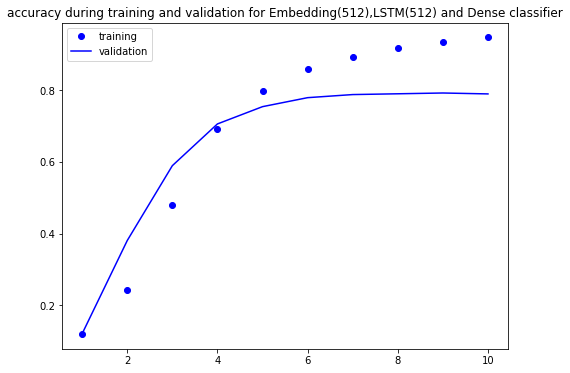

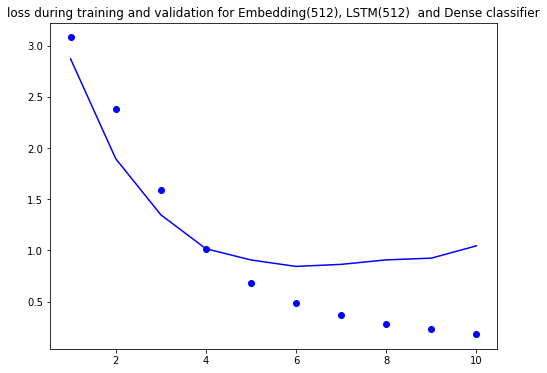

In [12]:
#display accuracy and loss for both training and validation set of text designation_str_tokens after epochs execution
#typical overfitting neural network 
#with accuracy increasing linearly on training set to almost reaching 100%
#and stabilized around 79% for validation
#adding of a LSTM layer is not increasing the performance of the model
#
#No dimensionality configuration optimisation attempts on embedding output dense vector size and LSTM output
#
#no callback yet configured to stop training after epoch 6 for example
#
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1,len(acc)+1)
plt.figure(figsize=(8,6))
plt.plot(epochs,acc,'bo',label='training')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('accuracy during training and validation for Embedding(512),LSTM(512) and Dense classifier')
plt.legend();

plt.figure(figsize=(8,6))     
plt.plot(epochs,loss,'bo',label='training')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('loss during training and validation for Embedding(512), LSTM(512)  and Dense classifier')

In [13]:
model2 = Sequential()


model2.add(Embedding(max_features+1,128,input_length=maxlen))
model2.add(LSTM(128))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(27,activation='softmax'))


model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 350, 128)          6374528   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 27)                1755      
Total params: 6,516,123
Trainable params: 6,516,123
Non-trainable params: 0
____________________________________________

In [14]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
import time

start = time.time()

history2 = model2.fit(X_train_2D, y_train.values,
    batch_size = 32,
    epochs=10,
    validation_data = [X_test_2D, y_test.values])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

Train on 67690 samples, validate on 16923 samples
Epoch 1/10
67690/67690 [==============================] - 138s 2ms/sample - loss: 3.1145 - accuracy: 0.1193 - val_loss: 3.0940 - val_accuracy: 0.1200
Epoch 2/10
67690/67690 [==============================] - 134s 2ms/sample - loss: 3.1005 - accuracy: 0.1209 - val_loss: 3.0921 - val_accuracy: 0.1208
Epoch 3/10
67690/67690 [==============================] - 133s 2ms/sample - loss: 3.0627 - accuracy: 0.1267 - val_loss: 2.7779 - val_accuracy: 0.1670
Epoch 4/10
67690/67690 [==============================] - 134s 2ms/sample - loss: 1.9916 - accuracy: 0.3667 - val_loss: 1.4568 - val_accuracy: 0.5317
Epoch 5/10
67690/67690 [==============================] - 134s 2ms/sample - loss: 1.2044 - accuracy: 0.6065 - val_loss: 1.0750 - val_accuracy: 0.6691
Epoch 6/10
67690/67690 [==============================] - 135s 2ms/sample - loss: 0.8075 - accuracy: 0.7526 - val_loss: 0.9190 - val_accuracy: 0.7344
Epoch 7/10
67690/67690 [==========================

Text(0.5, 1.0, 'loss during training and validation for Embedding(128), LSTM(128)  and Dense classifier')

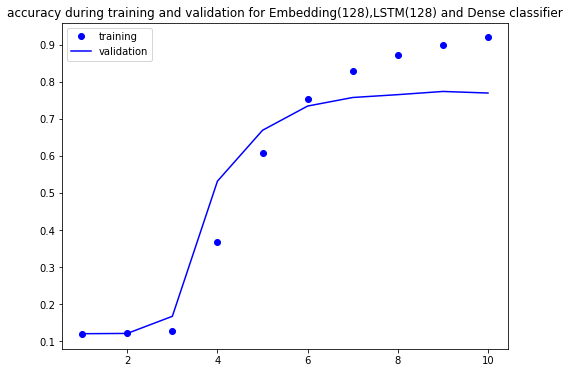

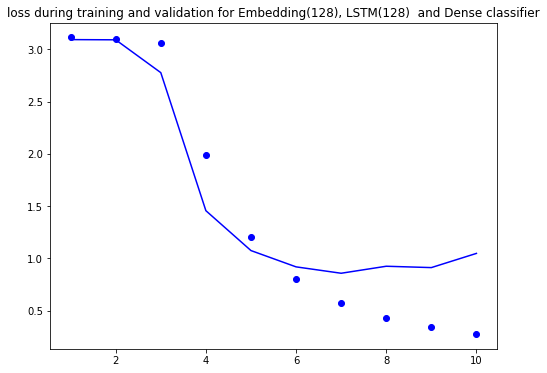

In [16]:
#display accuracy and loss for both training and validation set of text designation_str_tokens after epochs execution
#typical overfitting neural network 
#with accuracy increasing linearly on training set to almost reaching 100%
#and stabilized around 77% for validation
#adding of a LSTM layer is not increasing the performance of the model
#
#attempt to pass embedding output dense vector size from 512 to 128  and LSTM output same size too
#
#no callback yet configured to stop training after epoch 7 for example
#
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1,len(acc)+1)
plt.figure(figsize=(8,6))
plt.plot(epochs,acc,'bo',label='training')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('accuracy during training and validation for Embedding(128),LSTM(128) and Dense classifier')
plt.legend();

plt.figure(figsize=(8,6))     
plt.plot(epochs,loss,'bo',label='training')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('loss during training and validation for Embedding(128), LSTM(128)  and Dense classifier')

In [7]:
#cell to be used for models with embedding layer expecting text input fixed size of 200 words
from keras import preprocessing

#number of word considered by embedding layer as all possible characteristics (dictionary of vocabulary)
max_features = 49800

#text truncated if its length is higher
maxlen=200



#transform list of integers into a tensor2D
X_train_2D = tf.keras.preprocessing.sequence.pad_sequences(X_train_int,maxlen=maxlen,padding='post',truncating='post')
X_test_2D = tf.keras.preprocessing.sequence.pad_sequences(X_test_int,maxlen=maxlen,padding='post',truncating='post')
print("tensor2D size of the test set :",X_test_2D.shape)
print("first raw text of test set  :\n",X_test.iloc[0])
print("")
print("text converted into integers list:",X_test_int[0])
print("")
print("first tensor :\n",X_test_2D[0])

training tensor2D size : (67690, 200)


In [19]:
model3 = Sequential()


model3.add(Embedding(max_features+1,128,input_length=maxlen200))
model3.add(LSTM(128))
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(27,activation='softmax'))


model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          6374528   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 27)                1755      
Total params: 6,516,123
Trainable params: 6,516,123
Non-trainable params: 0
____________________________________________

In [20]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
import time

start = time.time()

history3 = model3.fit(X_train_2D_200, y_train.values,
    batch_size = 32,
    epochs=15,
    validation_data = [X_test_2D_200, y_test.values])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

Train on 67690 samples, validate on 16923 samples
Epoch 1/15
67690/67690 [==============================] - 118s 2ms/sample - loss: 3.0743 - accuracy: 0.1284 - val_loss: 3.0468 - val_accuracy: 0.1330
Epoch 2/15
67690/67690 [==============================] - 116s 2ms/sample - loss: 2.3683 - accuracy: 0.2670 - val_loss: 1.5322 - val_accuracy: 0.5292
Epoch 3/15
67690/67690 [==============================] - 116s 2ms/sample - loss: 1.1046 - accuracy: 0.6609 - val_loss: 0.9031 - val_accuracy: 0.7315
Epoch 4/15
67690/67690 [==============================] - 117s 2ms/sample - loss: 0.6703 - accuracy: 0.8033 - val_loss: 0.7841 - val_accuracy: 0.7737
Epoch 5/15
67690/67690 [==============================] - 115s 2ms/sample - loss: 0.4645 - accuracy: 0.8653 - val_loss: 0.7705 - val_accuracy: 0.7851
Epoch 6/15
67690/67690 [==============================] - 115s 2ms/sample - loss: 0.3428 - accuracy: 0.9013 - val_loss: 0.8492 - val_accuracy: 0.7835
Epoch 7/15
67690/67690 [==========================

Text(0.5, 1.0, 'loss during training and validation for Embedding(128), LSTM(128) and Dense classifier based on 200 words per text product')

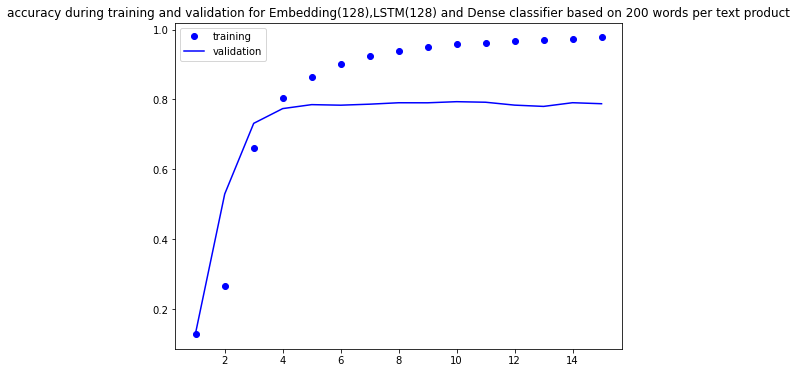

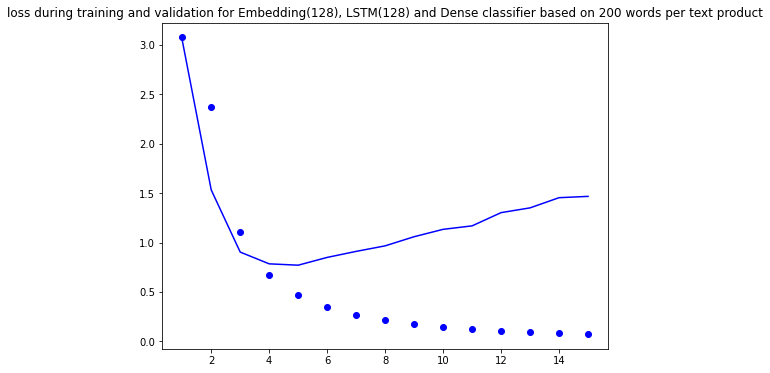

In [22]:
#display accuracy and loss for both training and validation set of text designation_str_tokens after epochs execution
#typical overfitting neural network 
#with accuracy increasing linearly on training set to almost reaching 100%
#and stabilized around 79% for validation
#adding of a LSTM layer is not increasing the performance of the model
#
#attempt to pass embedding output dense vector size from 512 to 128  and LSTM output same size too
#reduce input length of embedding layer (words number used from 350 to 200) not meaningfull
#
#unfortunately, no callback yet configured to stop training after epoch 5 for example
#
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1,len(acc)+1)
plt.figure(figsize=(8,6))
plt.plot(epochs,acc,'bo',label='training')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('accuracy during training and validation for Embedding(128),LSTM(128) and Dense classifier based on 200 words per text product')
plt.legend();

plt.figure(figsize=(8,6))     
plt.plot(epochs,loss,'bo',label='training')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('loss during training and validation for Embedding(128), LSTM(128) and Dense classifier based on 200 words per text product')

In [23]:
model4 = Sequential()


model4.add(Embedding(max_features+1,640,input_length=maxlen200))
model4.add(LSTM(640))
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(27,activation='softmax'))


model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 640)          31872640  
_________________________________________________________________
lstm_3 (LSTM)                (None, 640)               3279360   
_________________________________________________________________
flatten_3 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                41024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 27)                1755      
Total params: 35,194,779
Trainable params: 35,194,779
Non-trainable params: 0
__________________________________________

In [24]:
model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
import time

start = time.time()

history4 = model4.fit(X_train_2D_200, y_train.values,
    batch_size = 32,
    epochs=15,
    validation_data = [X_test_2D_200, y_test.values])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

ERROR! Session/line number was not unique in database. History logging moved to new session 157
Train on 67690 samples, validate on 16923 samples
Epoch 1/15
67690/67690 [==============================] - 527s 8ms/sample - loss: 3.1201 - accuracy: 0.1180 - val_loss: 3.0880 - val_accuracy: 0.1207
Epoch 2/15
67690/67690 [==============================] - 522s 8ms/sample - loss: 2.1714 - accuracy: 0.3274 - val_loss: 1.2984 - val_accuracy: 0.5861
Epoch 3/15
67690/67690 [==============================] - 521s 8ms/sample - loss: 1.0191 - accuracy: 0.6925 - val_loss: 0.8618 - val_accuracy: 0.7427
Epoch 4/15
67690/67690 [==============================] - 520s 8ms/sample - loss: 0.6371 - accuracy: 0.8114 - val_loss: 0.7621 - val_accuracy: 0.7786
Epoch 5/15
67690/67690 [==============================] - 522s 8ms/sample - loss: 0.4433 - accuracy: 0.8675 - val_loss: 0.7212 - val_accuracy: 0.7968
Epoch 6/15
67690/67690 [==============================] - 524s 8ms/sample - loss: 0.3256 - accuracy: 0.9

Text(0.5, 1.0, 'loss during training and validation for Embedding(640), LSTM(640) and Dense classifier based on 200 words per text product')

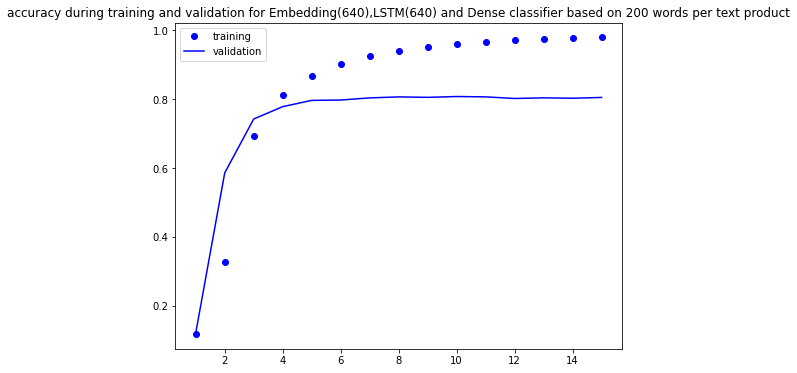

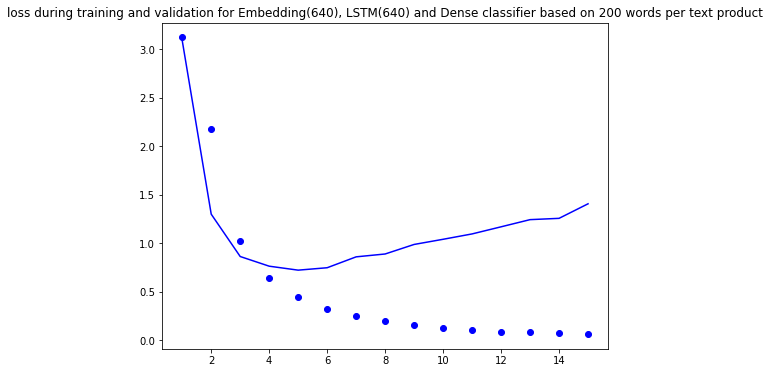

In [26]:
#display accuracy and loss for both training and validation set of text designation_str_tokens after epochs execution
#typical overfitting neural network 
#with accuracy increasing linearly on training set to almost reaching 100%
#and stabilized around 80,5% for validation
#adding of a LSTM layer is not increasing the performance of the model
#
#attempt to pass embedding output dense vector size from 512 to 640  and LSTM output same size too
#reduce input length of embedding layer (words number used from 350 to 200) not meaningfull
#
#unfortunately, no callback yet configured to stop training after epoch 6 for example
#
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(1,len(acc)+1)
plt.figure(figsize=(8,6))
plt.plot(epochs,acc,'bo',label='training')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('accuracy during training and validation for Embedding(640),LSTM(640) and Dense classifier based on 200 words per text product')
plt.legend();

plt.figure(figsize=(8,6))     
plt.plot(epochs,loss,'bo',label='training')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('loss during training and validation for Embedding(640), LSTM(640) and Dense classifier based on 200 words per text product')

In [9]:
from tensorflow.keras.layers import GRU

model5 = Sequential()

model5.add(Embedding(max_features+1,640,input_length=maxlen200))
model5.add(GRU(640))
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(27,activation='softmax'))


model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 640)          31872640  
_________________________________________________________________
gru (GRU)                    (None, 640)               2461440   
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                41024     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                1755      
Total params: 34,376,859
Trainable params: 34,376,859
Non-trainable params: 0
____________________________________________

In [10]:
model5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
import time

start = time.time()

history5 = model5.fit(X_train_2D_200, y_train.values,
    batch_size = 32,
    epochs=15,
    validation_data = [X_test_2D_200, y_test.values])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

Train on 67690 samples, validate on 16923 samples
Epoch 1/15
67690/67690 [==============================] - 521s 8ms/sample - loss: 1.8038 - accuracy: 0.4743 - val_loss: 0.7908 - val_accuracy: 0.7633
Epoch 2/15
67690/67690 [==============================] - 515s 8ms/sample - loss: 0.6123 - accuracy: 0.8166 - val_loss: 0.6234 - val_accuracy: 0.8131
Epoch 3/15
67690/67690 [==============================] - 515s 8ms/sample - loss: 0.3679 - accuracy: 0.8882 - val_loss: 0.6413 - val_accuracy: 0.8201
Epoch 4/15
67690/67690 [==============================] - 518s 8ms/sample - loss: 0.2463 - accuracy: 0.9234 - val_loss: 0.7001 - val_accuracy: 0.8189
Epoch 5/15
67690/67690 [==============================] - 521s 8ms/sample - loss: 0.1795 - accuracy: 0.9432 - val_loss: 0.7952 - val_accuracy: 0.8162
Epoch 6/15
67690/67690 [==============================] - 517s 8ms/sample - loss: 0.1431 - accuracy: 0.9539 - val_loss: 0.9071 - val_accuracy: 0.8168
Epoch 7/15
67690/67690 [==========================

Text(0.5, 1.0, 'loss during training and validation for Embedding(640), GRU(640) and Dense classifier based on 200 words per text product')

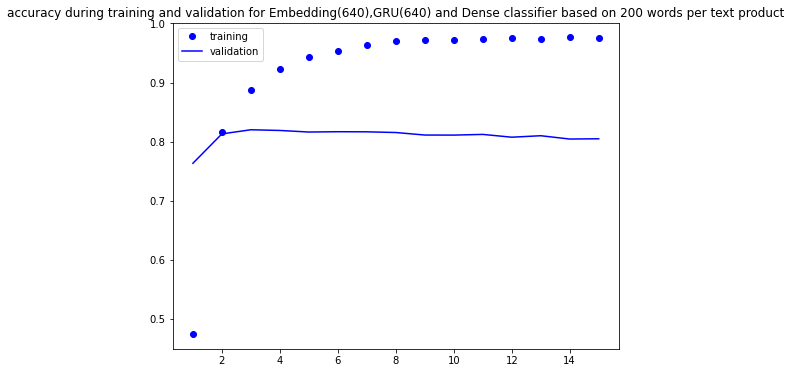

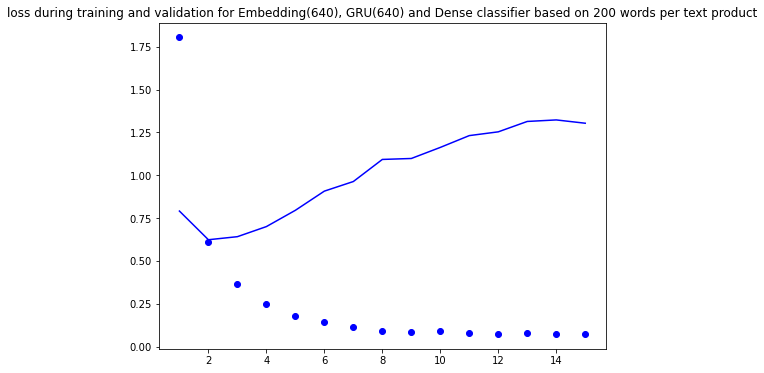

In [12]:
#display accuracy and loss for both training and validation set of text designation_str_tokens after epochs execution
#typical overfitting neural network 
#with accuracy increasing linearly on training set to almost reaching 100%
#and stabilized around 81,5% for validation
#adding of a GRU layer is increasing slightly the performance of the model with only embedding and dense classifier
#
#try GRU rather LSTM as recurrent layer
#attempt to pass embedding output dense vector size from 512 to 640
#reduce input length of embedding layer (words number used from 350 to 200) not meaningfull
#
#unfortunately, no callback yet configured to stop training after epoch 3 only  !!!!
#
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(1,len(acc)+1)
plt.figure(figsize=(8,6))
plt.plot(epochs,acc,'bo',label='training')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('accuracy during training and validation for Embedding(640),GRU(640) and Dense classifier based on 200 words per text product')
plt.legend();

plt.figure(figsize=(8,6))     
plt.plot(epochs,loss,'bo',label='training')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('loss during training and validation for Embedding(640), GRU(640) and Dense classifier based on 200 words per text product')

In [ ]:
#problem on my personal configuration with GPU
#
#when implicit dropout=0.2 and recurrent_dropout=0.2 are configured for LSTM layer
#epoch 1 is displayed BUT batch bar advancement is never appearing !!!!!!!!!!!!!!
#seems related to tf2.0 with memory leakage (using mprof to run a python script mprof plot to display increase)
#no time to try to debug using CustomDataGen to build every batch rather than batch internally constructed by fit 

In [13]:
model6 = Sequential()


model6.add(Embedding(max_features+1,640,input_length=maxlen200))

model6.add(Flatten())
model6.add(Dense(64, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(27,activation='softmax'))


model6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 640)          31872640  
_________________________________________________________________
flatten_1 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8192064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 27)                1755      
Total params: 40,066,459
Trainable params: 40,066,459
Non-trainable params: 0
_________________________________________________________________


In [14]:
model6.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
import time

start = time.time()

history6 = model6.fit(X_train_2D_200, y_train.values,
    batch_size = 32,
    epochs=15,
    validation_data = [X_test_2D_200, y_test.values])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

Train on 67690 samples, validate on 16923 samples
Epoch 1/15
67690/67690 [==============================] - 491s 7ms/sample - loss: 1.0795 - accuracy: 0.6917 - val_loss: 0.6487 - val_accuracy: 0.8067
Epoch 2/15
67690/67690 [==============================] - 487s 7ms/sample - loss: 0.3323 - accuracy: 0.9014 - val_loss: 0.7216 - val_accuracy: 0.8025
Epoch 3/15
67690/67690 [==============================] - 488s 7ms/sample - loss: 0.1853 - accuracy: 0.9489 - val_loss: 0.8974 - val_accuracy: 0.8038
Epoch 4/15
67690/67690 [==============================] - 488s 7ms/sample - loss: 0.1437 - accuracy: 0.9627 - val_loss: 1.0562 - val_accuracy: 0.7985
Epoch 5/15
67690/67690 [==============================] - 488s 7ms/sample - loss: 0.1285 - accuracy: 0.9692 - val_loss: 1.2053 - val_accuracy: 0.7913
Epoch 6/15
67690/67690 [==============================] - 486s 7ms/sample - loss: 0.0997 - accuracy: 0.9740 - val_loss: 1.3088 - val_accuracy: 0.7904
Epoch 7/15
67690/67690 [==========================

Text(0.5, 1.0, 'loss during training and validation for Embedding(640) and Dense classifier based on 200 words per text product')

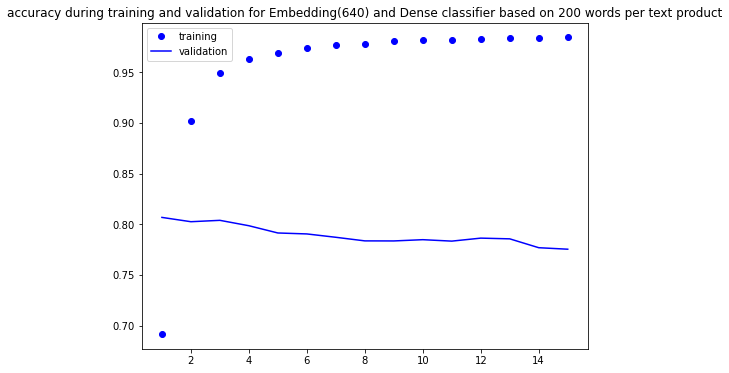

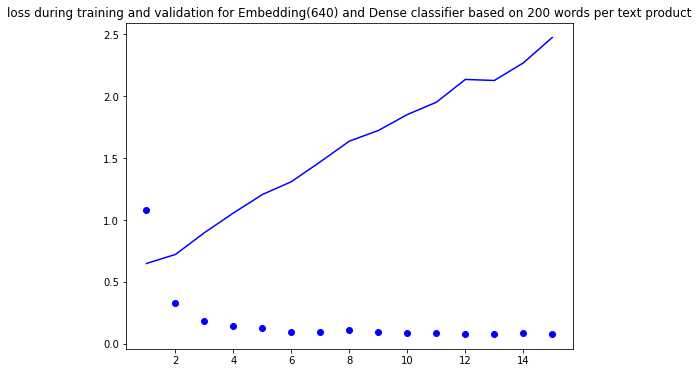

In [16]:
#display accuracy and loss for both training and validation set of text designation_str_tokens after epochs execution
#typical overfitting neural network 
#with accuracy increasing linearly on training set to almost reaching 100%
#and stabilized around 80 % for validation
#
#no RNN layer
#attempt to pass embedding output dense vector size from 512 to 640
#reduce input length of embedding layer (text size : words number used from 350 to 200) not meaningfull
#
#unfortunately, no callback yet configured to stop training after epoch 2 only  !!!!
#
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs = range(1,len(acc)+1)
plt.figure(figsize=(8,6))
plt.plot(epochs,acc,'bo',label='training')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('accuracy during training and validation for Embedding(640) and Dense classifier based on 200 words per text product')
plt.legend();

plt.figure(figsize=(8,6))     
plt.plot(epochs,loss,'bo',label='training')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('loss during training and validation for Embedding(640) and Dense classifier based on 200 words per text product')

In [11]:
#cell with epochs=4 hard coded to save the BEST model weights !!!!!!!!!!!!!!
#at right moment when validation loss and performance on accuracy are the best
import time

start = time.time()

history5 = model5.fit(X_train_2D_200, y_train.values,
    batch_size = 32,
    epochs=4,
    validation_data = [X_test_2D_200, y_test.values])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

#good practise : always save model after training
model5.save('Rakuten_text_embedding_200words_640_GRU_640_dense_64_27_after_3epochs.h5')

Train on 67690 samples, validate on 16923 samples
Epoch 1/4
67690/67690 [==============================] - 519s 8ms/sample - loss: 2.0945 - accuracy: 0.3950 - val_loss: 0.8380 - val_accuracy: 0.7512
Epoch 2/4
67690/67690 [==============================] - 514s 8ms/sample - loss: 0.6754 - accuracy: 0.8014 - val_loss: 0.6314 - val_accuracy: 0.8078
Epoch 3/4
67690/67690 [==============================] - 513s 8ms/sample - loss: 0.3943 - accuracy: 0.8796 - val_loss: 0.6435 - val_accuracy: 0.8164
Epoch 4/4
67690/67690 [==============================] - 514s 8ms/sample - loss: 0.2652 - accuracy: 0.9184 - val_loss: 0.7033 - val_accuracy: 0.8191

cell execution duration : 34.00 mn


In [9]:
#model ConvNet1D working on spatial dimension of the text already converted into dense vector
model7 = Sequential()

model7.add(Embedding(max_features+1, 640, input_length=maxlen200))
model7.add(Conv1D(32, 9, activation='relu'))
model7.add(MaxPooling1D(5))
model7.add(Conv1D(32, 9, activation='relu'))
model7.add(GlobalMaxPooling1D())
model7.add(Dense(64, activation='relu'))
model7.add(Dropout(0.2))
model7.add(Dense(27,activation='softmax'))


model7.summary()

ERROR! Session/line number was not unique in database. History logging moved to new session 166
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 640)          31872640  
_________________________________________________________________
conv1d (Conv1D)              (None, 192, 32)           184352    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 32)            9248      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
________________________

In [10]:
model7.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
import time

start = time.time()

history7 = model7.fit(X_train_2D_200, y_train.values,
    batch_size = 32,
    epochs=15,
    validation_data = [X_test_2D_200, y_test.values])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

Train on 67690 samples, validate on 16923 samples
Epoch 1/15
67690/67690 [==============================] - 497s 7ms/sample - loss: 1.3521 - accuracy: 0.5966 - val_loss: 0.8233 - val_accuracy: 0.7577
Epoch 2/15
67690/67690 [==============================] - 491s 7ms/sample - loss: 0.6293 - accuracy: 0.8102 - val_loss: 0.7293 - val_accuracy: 0.7862
Epoch 3/15
67690/67690 [==============================] - 491s 7ms/sample - loss: 0.3845 - accuracy: 0.8812 - val_loss: 0.7622 - val_accuracy: 0.7879
Epoch 4/15
67690/67690 [==============================] - 489s 7ms/sample - loss: 0.2632 - accuracy: 0.9204 - val_loss: 0.8620 - val_accuracy: 0.7874
Epoch 5/15
67690/67690 [==============================] - 495s 7ms/sample - loss: 0.1942 - accuracy: 0.9407 - val_loss: 0.9738 - val_accuracy: 0.7866
Epoch 6/15
67690/67690 [==============================] - 494s 7ms/sample - loss: 0.1560 - accuracy: 0.9519 - val_loss: 1.0506 - val_accuracy: 0.7898
Epoch 7/15
67690/67690 [==========================

Text(0.5, 1.0, 'loss during training and validation for Embedding(640), ConvNet1D_32_9_MaxPool_5 and Dense classifier based on 200 words per text product')

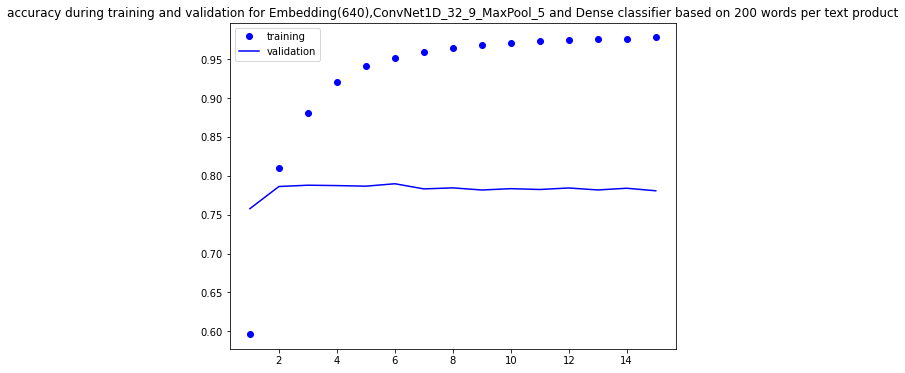

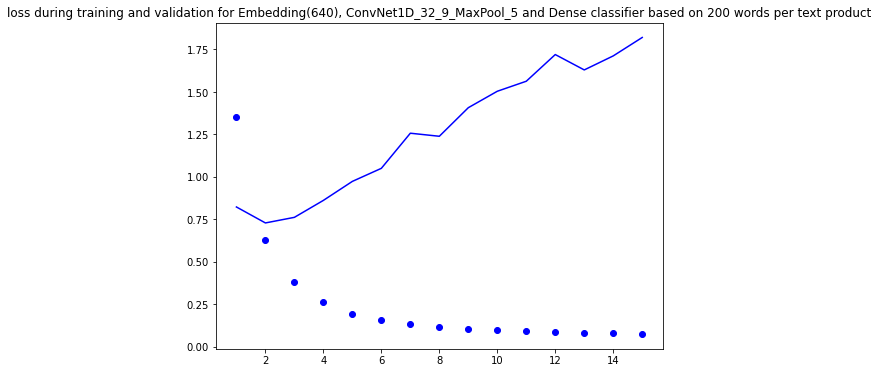

In [12]:
#display accuracy and loss for both training and validation set of text designation_str_tokens after epochs execution
#typical overfitting neural network 
#with accuracy increasing linearly on training set to almost reaching 100%
#and stabilized around 78,5 % for validation
#
#embedding output dense vector size 640
#input length of embedding layer (text size : words number used 200) 
##ConvNet1D with 32 filters applying a convolution window size of 9 and MaxPooling1D layer of 5 
#
#unfortunately, no callback yet configured to stop training after epoch 3 only  !!!!
#
acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']
loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs = range(1,len(acc)+1)
plt.figure(figsize=(8,6))
plt.plot(epochs,acc,'bo',label='training')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('accuracy during training and validation for Embedding(640),ConvNet1D_32_9_MaxPool_5 and Dense classifier based on 200 words per text product')
plt.legend();

plt.figure(figsize=(8,6))     
plt.plot(epochs,loss,'bo',label='training')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('loss during training and validation for Embedding(640), ConvNet1D_32_9_MaxPool_5 and Dense classifier based on 200 words per text product')

In [13]:
#model ConvNet1D working on spatial dimension of the text already converted into dense vector
#attempt to test using 64 filters rather 32 same spatial convolutional window size of 9
model8 = Sequential()

model8.add(Embedding(max_features+1, 640, input_length=maxlen200))
model8.add(Conv1D(64, 9, activation='relu'))
model8.add(MaxPooling1D(5))
model8.add(Conv1D(64, 9, activation='relu'))
model8.add(GlobalMaxPooling1D())
model8.add(Dense(64, activation='relu'))
model8.add(Dropout(0.2))
model8.add(Dense(27,activation='softmax'))


model8.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 640)          31872640  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 192, 64)           368704    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 38, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 30, 64)            36928     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [14]:
model8.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
import time

start = time.time()

history8 = model8.fit(X_train_2D_200, y_train.values,
    batch_size = 32,
    epochs=8,
    validation_data = [X_test_2D_200, y_test.values])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

Train on 67690 samples, validate on 16923 samples
Epoch 1/8
67690/67690 [==============================] - 491s 7ms/sample - loss: 1.2918 - accuracy: 0.6152 - val_loss: 0.7999 - val_accuracy: 0.7609
Epoch 2/8
67690/67690 [==============================] - 491s 7ms/sample - loss: 0.5915 - accuracy: 0.8205 - val_loss: 0.7027 - val_accuracy: 0.7932
Epoch 3/8
67690/67690 [==============================] - 490s 7ms/sample - loss: 0.3664 - accuracy: 0.8860 - val_loss: 0.7538 - val_accuracy: 0.7953
Epoch 4/8
67690/67690 [==============================] - 491s 7ms/sample - loss: 0.2546 - accuracy: 0.9210 - val_loss: 0.8720 - val_accuracy: 0.7911
Epoch 5/8
67690/67690 [==============================] - 490s 7ms/sample - loss: 0.1906 - accuracy: 0.9407 - val_loss: 0.9274 - val_accuracy: 0.7921
Epoch 6/8
67690/67690 [==============================] - 492s 7ms/sample - loss: 0.1498 - accuracy: 0.9547 - val_loss: 1.1025 - val_accuracy: 0.7911
Epoch 7/8
67690/67690 [==============================] -

Text(0.5, 1.0, 'loss during training and validation for Embedding(640), ConvNet1D_64_9_MaxPool_5 and Dense classifier based on 200 words per text product')

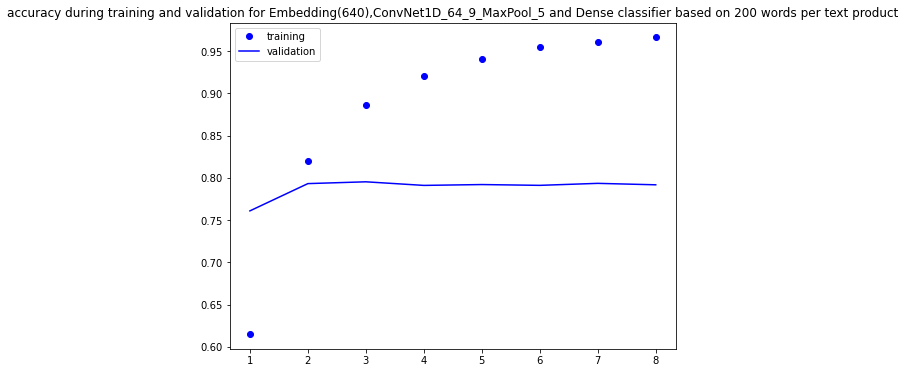

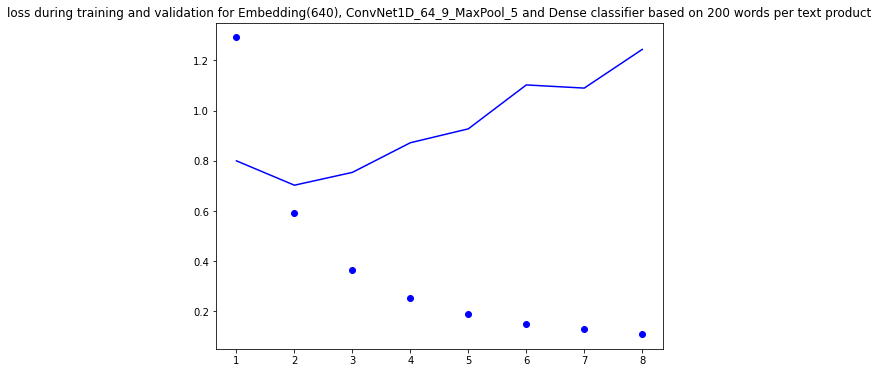

In [16]:
#display accuracy and loss for both training and validation set of text designation_str_tokens after epochs execution
#typical overfitting neural network 
#with accuracy increasing linearly on training set to almost reaching 100%
#and stabilized around 79,1 % for validation
#
#embedding output dense vector size 640
#input length of embedding layer (text size : words number used 200) 
##ConvNet1D with 64 filters applying a convolution window size of 9 and MaxPooling1D layer of 5 
#
#unfortunately, no callback yet configured to stop training after epoch 3 only  !!!!
#
acc = history8.history['accuracy']
val_acc = history8.history['val_accuracy']
loss = history8.history['loss']
val_loss = history8.history['val_loss']

epochs = range(1,len(acc)+1)
plt.figure(figsize=(8,6))
plt.plot(epochs,acc,'bo',label='training')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('accuracy during training and validation for Embedding(640),ConvNet1D_64_9_MaxPool_5 and Dense classifier based on 200 words per text product')
plt.legend();

plt.figure(figsize=(8,6))     
plt.plot(epochs,loss,'bo',label='training')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('loss during training and validation for Embedding(640), ConvNet1D_64_9_MaxPool_5 and Dense classifier based on 200 words per text product')

In [17]:
#model ConvNet1D working on spatial dimension of the text already converted into dense vector
#attempt to test using 96 filters rather 32 same spatial convolutional window size of 7
model9 = Sequential()

model9.add(Embedding(max_features+1, 640, input_length=maxlen200))
model9.add(Conv1D(96, 7, activation='relu'))
model9.add(MaxPooling1D(4))
model9.add(Conv1D(96, 7, activation='relu'))
model9.add(GlobalMaxPooling1D())
model9.add(Dense(64, activation='relu'))
model9.add(Dropout(0.2))
model9.add(Dense(27,activation='softmax'))


model9.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 640)          31872640  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 194, 96)           430176    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 48, 96)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 42, 96)            64608     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 96)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6208      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [18]:
model9.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
import time

start = time.time()

history9 = model9.fit(X_train_2D_200, y_train.values,
    batch_size = 32,
    epochs=8,
    validation_data = [X_test_2D_200, y_test.values])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

Train on 67690 samples, validate on 16923 samples
Epoch 1/8
67690/67690 [==============================] - 496s 7ms/sample - loss: 1.2332 - accuracy: 0.6328 - val_loss: 0.7653 - val_accuracy: 0.7708
Epoch 2/8
67690/67690 [==============================] - 492s 7ms/sample - loss: 0.5667 - accuracy: 0.8282 - val_loss: 0.7115 - val_accuracy: 0.7913
Epoch 3/8
67690/67690 [==============================] - 492s 7ms/sample - loss: 0.3568 - accuracy: 0.8888 - val_loss: 0.7456 - val_accuracy: 0.7974
Epoch 4/8
67690/67690 [==============================] - 490s 7ms/sample - loss: 0.2459 - accuracy: 0.9239 - val_loss: 0.8557 - val_accuracy: 0.7956
Epoch 5/8
67690/67690 [==============================] - 490s 7ms/sample - loss: 0.1811 - accuracy: 0.9436 - val_loss: 0.9736 - val_accuracy: 0.7980
Epoch 6/8
67690/67690 [==============================] - 491s 7ms/sample - loss: 0.1445 - accuracy: 0.9564 - val_loss: 1.0444 - val_accuracy: 0.7944
Epoch 7/8
67690/67690 [==============================] -

Text(0.5, 1.0, 'loss during training and validation for Embedding(640), ConvNet1D_96_7_MaxPool_4 and Dense classifier based on 200 words per text product')

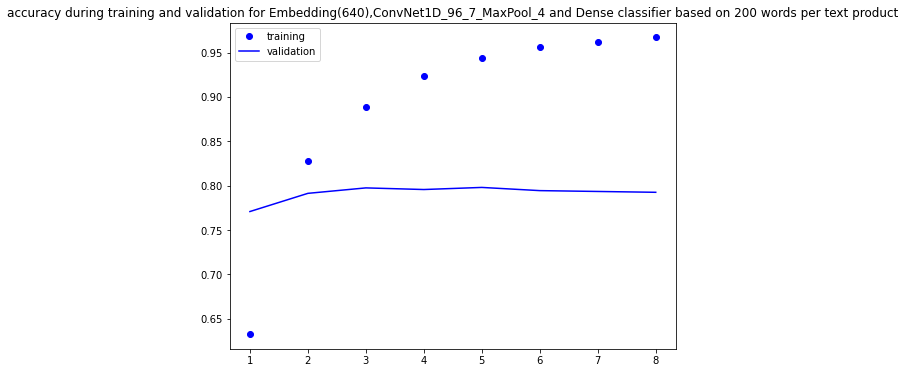

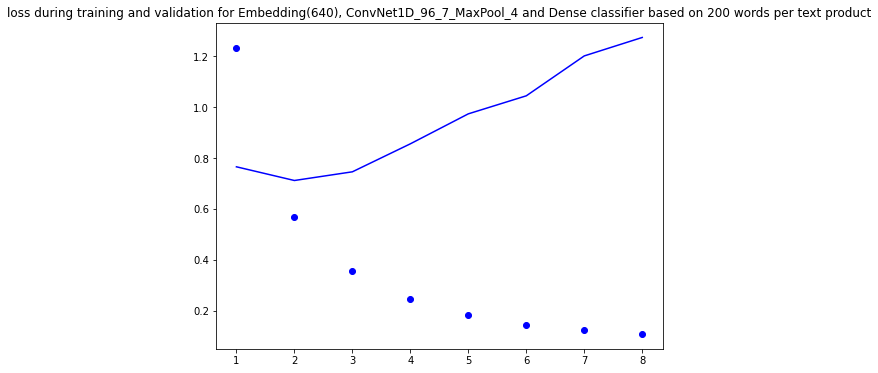

In [20]:
#display accuracy and loss for both training and validation set of text designation_str_tokens after epochs execution
#typical overfitting neural network 
#with accuracy increasing linearly on training set to almost reaching 100%
#and stabilized around 79,1 % for validation
#
#embedding output dense vector size 640
#input length of embedding layer (text size : words number used 200) 
##ConvNet1D with 96 filters applying a convolution window size of 7 and MaxPooling1D layer of 4 
#
#unfortunately, no callback yet configured to stop training after epoch 3 only  !!!!
#
acc = history9.history['accuracy']
val_acc = history9.history['val_accuracy']
loss = history9.history['loss']
val_loss = history9.history['val_loss']

epochs = range(1,len(acc)+1)
plt.figure(figsize=(8,6))
plt.plot(epochs,acc,'bo',label='training')
plt.plot(epochs,val_acc,'b',label='validation')
plt.title('accuracy during training and validation for Embedding(640),ConvNet1D_96_7_MaxPool_4 and Dense classifier based on 200 words per text product')
plt.legend();

plt.figure(figsize=(8,6))     
plt.plot(epochs,loss,'bo',label='training')
plt.plot(epochs,val_loss,'b',label='validation')
plt.title('loss during training and validation for Embedding(640), ConvNet1D_96_7_MaxPool_4 and Dense classifier based on 200 words per text product')

In [13]:
#callback to stop training phase when val_loss is no more decreasing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=2,
                                         mode='min',
                                         restore_best_weights=True)

import time

start = time.time()

history5es = model5.fit(X_train_2D_200, y_train.values,
    batch_size = 32,
    epochs=10,
    validation_data = [X_test_2D_200, y_test.values],
    callbacks=[early_stopping])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')
#correctly stopped before hard coded 10 epochs requested initially

ERROR! Session/line number was not unique in database. History logging moved to new session 168
Train on 67690 samples, validate on 16923 samples
Epoch 1/10
67690/67690 [==============================] - 520s 8ms/sample - loss: 1.8546 - accuracy: 0.4501 - val_loss: 0.8515 - val_accuracy: 0.7456
Epoch 2/10
67690/67690 [==============================] - 515s 8ms/sample - loss: 0.6735 - accuracy: 0.8011 - val_loss: 0.6505 - val_accuracy: 0.8067
Epoch 3/10
67690/67690 [==============================] - 514s 8ms/sample - loss: 0.4068 - accuracy: 0.8773 - val_loss: 0.6535 - val_accuracy: 0.8157
Epoch 4/10
67690/67690 [==============================] - 516s 8ms/sample - loss: 0.2777 - accuracy: 0.9152 - val_loss: 0.7224 - val_accuracy: 0.8140

cell execution duration : 34.00 mn


In [11]:
#usage of TensorBoard on RNN GRU best model
#callback early_stopping not useful as it can only monitor loss or accuracy when used with Tensorboard callback !!!!
#run in CMD terminal : tensorboard --logdir=my_log_dir_full_path
#GUI operational on URL http://localhost:6006/
#tabulations : scalars (epoch_accuracy and loss), graphs, distributions, histograms and time series

cb_tb = tf.keras.callbacks.TensorBoard(log_dir='my_log_dir',histogram_freq=1,embeddings_freq=1)
# use of TensorBoard GUI to study training process
import time

start = time.time()

history5es_tb = model5.fit(X_train_2D_200, y_train.values,
    batch_size = 32,
    epochs=4,
    validation_data = [X_test_2D_200, y_test.values],
    callbacks=[cb_tb])

end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

Train on 67690 samples, validate on 16923 samples
Epoch 1/4
67690/67690 [==============================] - 529s 8ms/sample - loss: 2.0163 - accuracy: 0.4109 - val_loss: 0.8885 - val_accuracy: 0.7346
Epoch 2/4
67690/67690 [==============================] - 525s 8ms/sample - loss: 0.7005 - accuracy: 0.7938 - val_loss: 0.6912 - val_accuracy: 0.7951
Epoch 3/4
67690/67690 [==============================] - 530s 8ms/sample - loss: 0.4199 - accuracy: 0.8714 - val_loss: 0.6840 - val_accuracy: 0.8064
Epoch 4/4
67690/67690 [==============================] - 525s 8ms/sample - loss: 0.2839 - accuracy: 0.9123 - val_loss: 0.7200 - val_accuracy: 0.8143

cell execution duration : 35.00 mn


In [20]:
#elementary display of one text and its class prediction
from tensorflow.keras.models import load_model
from keras import preprocessing
best_model = load_model('Rakuten_text_embedding_200words_640_GRU_640_dense_64_27_after_3epochs.h5')

def transform_text(text):
    """function that converts an text (fixed length of 200 words) into a tensor 2D"""
    
    # text converted into integers
    text_int = tokenizer.texts_to_sequences(text)
    #text truncated if its length is higher
    maxlen200=200

    #transform list of integers into a tensor2D
    X_test_2D_200 = tf.keras.preprocessing.sequence.pad_sequences(text_int,maxlen=maxlen200,padding='post',truncating='post')

    
    return X_test_2D_200


txt_tensor = transform_text([X_test.iloc[0]])
test_pred = best_model.predict(txt_tensor)
print("shape of tensor2D given to model :",txt_tensor.shape)
print("shape of prediction :",test_pred.shape)
test_pred_class_txt = test_pred.argmax(axis = 1)
print("")
print("text to be classified in one of the 27 Rakuten classes :\n",X_test.iloc[0])
print("")
print("Rakuten class used by model of this product text : ",y_test.iloc[0])
print("")
print("corresponding tensor as input to model embedding layer :\n")
print(txt_tensor)
print("")
print("predicted probabilities of the 27 classes :\n",test_pred)
print("")
print("predicted class by model : ",test_pred_class_txt)
print("")
print("predicted product class for this text  :",list_class[test_pred_class_txt[0]], name_class[test_pred_class_txt[0]])
print("      real Rakuten class               :",list_class[y_test.iloc[0]], name_class[y_test.iloc[0]])



shape of tensor2D given to model : (1, 200)
shape of prediction : (1, 27)

text to be classified in one of the 27 Rakuten classes :
 [happy father day canape lire accueil decoration coussin festival taie oreiller couverture happy father day canape lit decoration pillow festival coussin case specification couvertur parfait place canape cafe bibliothequ livre party club magasin materiau forme lin place amovible lavable type tai oreiller deviation mesure comprendre forfait forfait tai oreiller]

Rakuten class used by model of this product text :  9

corresponding tensor as input to model embedding layer :

[[ 1285 27138  2584    90   978   304    10     8   811    60     7    49
   1285 27138  2584    90   106    10   821   811     8   436    83  1486
     54    84    90   293   941    81   416   677   616    18    34   226
     84   287   252    22   211     7   693    32   102    48    48   211
      7     0     0     0     0     0     0     0     0     0     0     0
      0     0     0

In [21]:
#Note : global prediction on X_test, data set not completely unknown as already used for model validation 
#methodology train, validation and test sets not strictly respected :-)

import time

test_pred_class = []
y_test_class = []
num_classes = 27

start = time.time()
for i in range(len(X_test)):
    if ((i == 2000) | (i == 4000) | (i == 6000) | (i == 8000) | (i == 10000) | (i == 12000) | (i == 14000)):
        print("in progress : {0} samples over {1} done ".format(i,len(X_test)))
    txt_tensor = transform_text([X_test.iloc[i]])
    test_pred = best_model.predict(txt_tensor)
    test_pred_class_txt = test_pred.argmax(axis = 1)
    test_pred_class.append(list_class[test_pred_class_txt[0]])
    
    y_test_class.append(list_class[y_test.iloc[i]])
    
end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')
    

print(metrics.classification_report(y_test_class, test_pred_class))


print("top 3 worst f1-score for classes :",name_class[list_class.index(10)],name_class[list_class.index(1180)],name_class[list_class.index(1281)])


ERROR! Session/line number was not unique in database. History logging moved to new session 189
in progress : 2000 samples over 16923 done 
in progress : 4000 samples over 16923 done 
in progress : 6000 samples over 16923 done 
in progress : 8000 samples over 16923 done 
in progress : 10000 samples over 16923 done 
in progress : 12000 samples over 16923 done 
in progress : 14000 samples over 16923 done 

cell execution duration : 18.00 mn
              precision    recall  f1-score   support

          10       0.46      0.63      0.53       626
          40       0.63      0.69      0.66       488
          50       0.80      0.86      0.83       356
          60       0.93      0.82      0.87       172
        1140       0.72      0.84      0.77       520
        1160       0.93      0.85      0.89       787
        1180       0.69      0.57      0.62       162
        1280       0.77      0.72      0.74      1002
        1281       0.75      0.52      0.62       417
        1300    

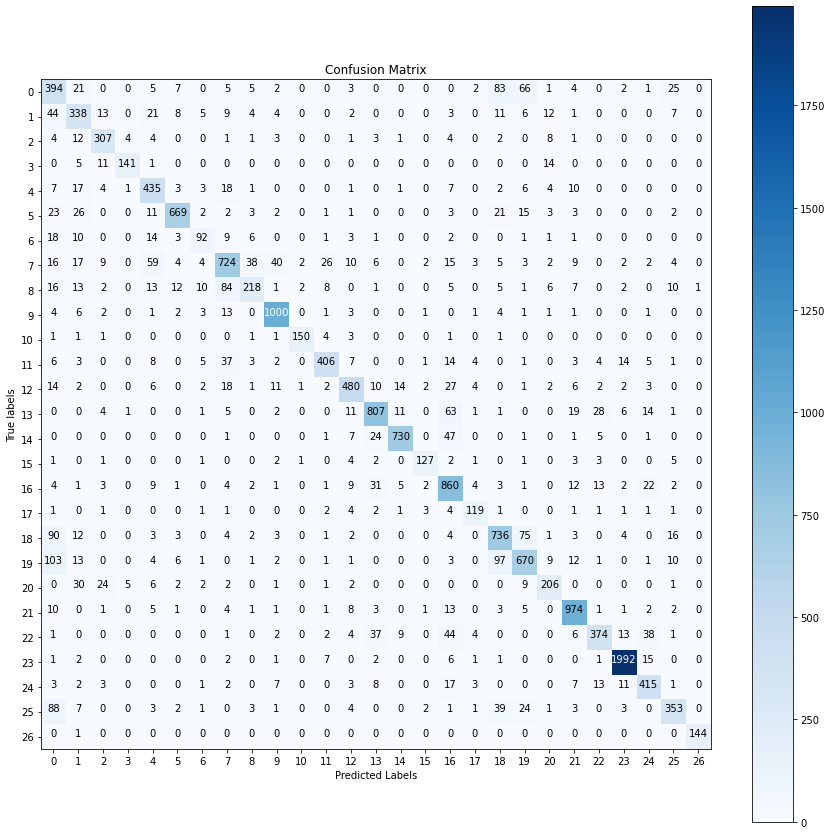

In [22]:
import matplotlib.pyplot as plt  
from sklearn import metrics 
import itertools # To create iterators

cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

classes = range(0,27)

plt.figure(figsize = (15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')
plt.show()


# comments from present text classification :
# real class 0 (editions) , lot of predictions on class 18 (jeux_video) and 19 (console_de_jeu) , little on class 25(articles_nourriture) too
# real class 1 (magazines) , lot of predictions on class 0 (editions)
# real class 7 (mobilier_interieur) , lot of predictions on class 4 (livres) , 8(jeux_enfants) and 9(literie)
# real class 11 (figurine) , lot of predictions on class 7 (mobilier_interieur)
# real class 18 (jeux_video) , lot of predictions on class 0 (editions) and 19 (console_de_jeu)
# real class 19 (console_de_jeu) , lot of predictions on class 0 (editions) and 18 (jeux_video)
# real class 13 (univers_de_fiction) , lot of predictions on class 16 (jeux_de_cartes_collection)
# real class 22 (materiel_animaux_compagnie) , lot of predictions on class 13 (univers_de_fiction) , 16(jeux_de_cartes_collection) and 24 (accessoires_outil)
# real class 25 (articles_nourriture) , lot of predictions on class 0 (editions)

In [31]:
#warning indices of classes for model metrics are not equal to Rakuten classes !!!!!!!
#threshold used : hard coded at 10% of accuracy number


#To try to understand wrong predictions of real class (editions) (one hot encoded 0)
for j in range(cnf_matrix.shape[0]):
    if(cnf_matrix[0,j] >39 and j!=0):
        mismatched_class = name_class[j]
        print("La classe {0} ({2} {3}) a souvent été pris pour la classe {1} ({4} {5}) ".format(0,j,list_class[0],name_class[0],list_class[j],name_class[j]))
print("")
#To try to understand wrong predictions of real class (editions) (one hot encoded 1)
for j in range(cnf_matrix.shape[0]):
    if(cnf_matrix[1,j] >34 and j!=1):
        mismatched_class = name_class[j]
        print("La classe {0} ({2} {3}) a souvent été pris pour la classe {1} ({4} {5}) ".format(1,j,list_class[1],name_class[1],list_class[j],name_class[j]))
print("")
#To try to understand wrong predictions of real class (articles_nourriture) (one hot encoded 25)
for j in range(cnf_matrix.shape[0]):
    if(cnf_matrix[25,j] >35 and j!=25):
        mismatched_class = name_class[j]
        print("La classe {0} ({2} {3}) a souvent été pris pour la classe {1} ({4} {5})".format(25,j,list_class[25],name_class[25],list_class[j],name_class[j]))
print("")        
print("Rappel des correspondances :")
name_class = ['editions','magazines',"equipement_playstation","jouets_enfant","livres","fournitures_scolaires","materiel_jardin","mobilier_interieur","jeux_enfants","literie","livres_par_lot","figurine","materiel_piscine","univers_de_fiction","equipements_telecommandes","materiel_jeux_video","jeux_de_cartes_collection","decoration","jeux_video","console_de_jeu","materiel_bebe","peche_lampe_plein_air","materiel_animaux_compagnie","jeux_sur_PC","accessoires_outil","articles_nourriture","vetements_nouveau-né_et_billard_flechettes"] 
list_class = [10, 2280 ,  50 ,1280 ,2705, 2522, 2582, 1560, 1281, 1920, 2403, 1140, 2583, 1180, 1300 ,2462, 1160, 2060 , 40,   60 ,1320 ,1302 ,2220 ,2905, 2585, 1940 ,1301]
list_class_onehot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]

df_link_class_nbr_name = pd.DataFrame({'class nbr Rakuten': list_class , 'class name given by team': name_class, 'class nbr from sklearn metrics': list_class_onehot })
display(df_link_class_nbr_name.head(len(df_link_class_nbr_name)))


La classe 0 (10 editions) a souvent été pris pour la classe 18 (40 jeux_video) 
La classe 0 (10 editions) a souvent été pris pour la classe 19 (60 console_de_jeu) 

La classe 1 (2280 magazines) a souvent été pris pour la classe 0 (10 editions) 

La classe 25 (1940 articles_nourriture) a souvent été pris pour la classe 0 (10 editions)
La classe 25 (1940 articles_nourriture) a souvent été pris pour la classe 18 (40 jeux_video)

Rappel des correspondances :


,class nbr Rakuten,class name given by team,class nbr from sklearn metrics
0,10,editions,0
1,2280,magazines,1
2,50,equipement_playstation,2
3,1280,jouets_enfant,3
4,2705,livres,4
5,2522,fournitures_scolaires,5
6,2582,materiel_jardin,6
7,1560,mobilier_interieur,7
8,1281,jeux_enfants,8
9,1920,literie,9
